In [1]:
%matplotlib inline
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from sklearn.manifold import TSNE

from torchsample.transforms import RangeNorm

import functions.fine_tune as ft
import functions.stats as st

plt.ion()   # interactive mode

/home/mtezcan/anaconda3/lib/python3.6/site-packages/torchsample-0.1.2-py3.6.egg/torchsample/datasets.py:16: UserWarning: Cant import nibabel.. Cant load brain images


In [2]:
model_ft=torch.load('./saved_models/resnet_synthetic_7_8_17.mdl')
criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.Adam(model_ft.parameters())
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#model_ft=model_ft.cpu()

In [3]:
rootdir='//media//mtezcan//New Volume//HoardingImages//_rated//'  
tr_dirs, tr_cir, tr_house, tr_room = st.subsetCreator(rootdir)

rootdir='//media//mtezcan//New Volume//HoardingImages//_val//'  
test_dirs, test_cir, test_house, test_room = st.subsetCreator(rootdir,im_per_room=100)

print('Created random directories')

model_params= list(model_ft.children())
network = nn.Sequential(*list(model_params)[:-1])
tr_fvec=st.extractFeats(tr_dirs,network)
test_fvec=st.extractFeats(test_dirs,network)

print('Constructed Features')

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tr_tsne=model.fit_transform(tr_fvec) 
test_tsne=model.fit_transform(test_fvec)

print('Constructed t-SNE embeddings')

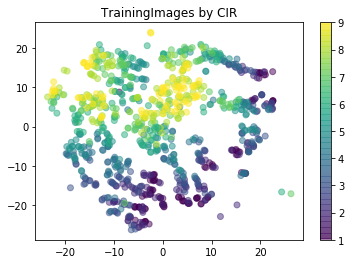

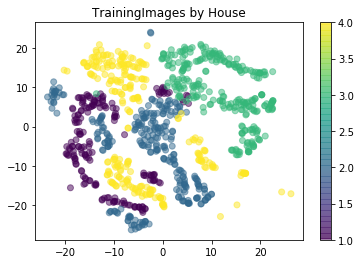

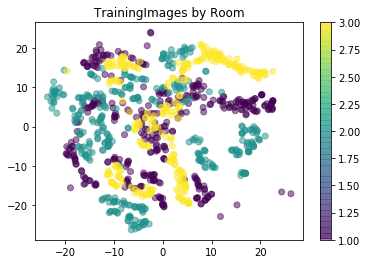

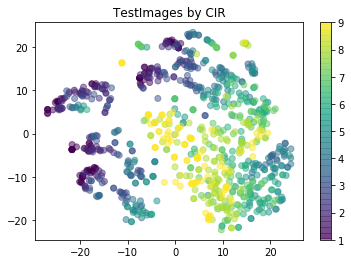

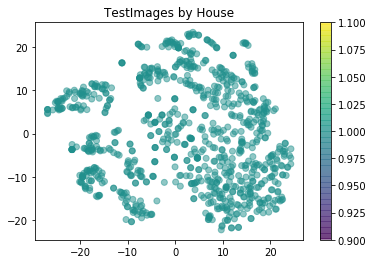

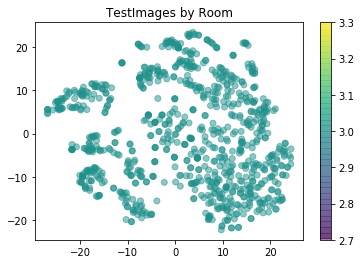

In [5]:
st.plotAll(tr_tsne,tr_cir,tr_house,tr_room,data_title='Training')
st.plotAll(test_tsne,test_cir,test_house,test_room,data_title='Test')